### Формулирование задачи
Отток клиентов является одной из главных проблем любой компании. Под оттоком клиентов понимается прекращение оплаты услуг или прекращение использования продукта компании. Процент клиентов, которые прекращают использовать продукт в течение определенного времени называется коэффициентом оттока клиентов. И если большая часть клиентов перестанет использовать продукт, то это сильно скажется на материальных потерях компании.

Основной идеей задачи является построение модели, которая будет предсказывать отток клиентов, использую предоставленные данные кредитной организации.

#### Входные данные
* RowNumber - номер строки;
* CustomerId - уникальный идентификатор клиента;
* Surname - клиент;
* Credit Score - кредитный рейтинг;
* Geography - страна, где находится клиент;
* Gender - половой признак;
* Age - возраст клиента;
* Tenure - стаж на последнем месте работы;
* Balance - остатки на всех счетах клиента, имеющихся в банке;
* NumOfProducts - количество продуктов у клиента;
* HasCrCard - признак наличия у клиента кредитной карты;
* IsActiveMember - признак активности пользователя;
* EstimatedSalary - заработная плата клиента;
* Exited - признак того, покинул клиент банк или нет

In [214]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
# настройка параметров визуализации
sns.set_theme(
    context={'font.size': 9},
    style='whitegrid'
)

In [3]:
data = pd.read_csv(r'data\Churn Modeling.csv').drop(columns='RowNumber')

### Первичный анализ данных
Проведем первичный анализ данных. Т.е. пробежимся глазами по данным и попробуем выявить в них какие-то особенности.

Сразу наблюдается, что у нас есть столбец `RowNumber`, который не несет никакой смысловой нагрузки. Поэтому удалим его на первоначальном этапе загрузки данных.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1015.8+ KB


In [5]:
data.isna().any(axis=1).all()

False

Отлично, данные не содержат пустых значений, также мы можем увидеть типы данных.

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
CreditScore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
Age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
Tenure,10000.0,5.012800e+00,2.892174,0.00,3.00,5.000000e+00,7.000000e+00,10.00
Balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
NumOfProducts,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
HasCrCard,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
IsActiveMember,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
EstimatedSalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48
Exited,10000.0,2.037000e-01,0.402769,0.00,0.00,0.000000e+00,0.000000e+00,1.00


Беглым взглядом мы можем обратить внимание на следующие вещи (выделим основные):
* скоринговый балл (он же кредитный рейтинг) принимает значение от 350 до 850;
* возраст наших клиентов от 18 до 92 лет;
* стаж работы наших клиентов принимает значения от 0 до 10, что является вполне логичным, т.к. возможно восемнадцатилетние клиенты являются студентами, но имеют счет в банке. Позже мы еще более подробно посмотрим на это;
* также можем обратить внимание, что в данных имеются клиенты с пустым балансом (остатки на счетах клиента равны 0);
* у каждого клиента имеется хоть один продукт, что является вполне логичным;
* встречаются клиенты, которые не имеют кредитной карты, но не меньше половины всех клиентов имеют кредитную карту (это можно увидеть, взглянув на пятидесятипроцентный персентиль);
* также можно сделать вывод, что не меньше половины всех клиентов являются активными (также обращая внимание на пятидесятипроцентный персентиль);
* минимальная заработная плата в анализируемых данных - `$11.58`, что является странным, но здесь все же можно найти логику если посмотреть на распределение наименьших зарплат в разрезе возраста. Есть предположение, что это клиенты не имеющие опыта работы. Возможно, это студенты, имеющие подработку. Позже мы также посмотрим на это более подробно.

In [7]:
print('Всего пользователей:', data.shape[0])
print('Уникальных пользователей:', data['CustomerId'].nunique())

Всего пользователей: 10000
Уникальных пользователей: 10000


Логично, что одна строка содержит одного пользователя, т.к. параметры таблицы описывают различную информацию о клиенте. Но все же стоит убедиться, что все представленные клиенты в срезе данных имеются в уникальном виде (т.е. не дублируются).

Ранее у нас было предположение, что клиенты с отсутствием трудового стажа являются достаточно молодыми. Казалось бы как данное предположение может повлиять на будущую модель, но таким скорым анализом мы проверяем согласованность данных (т.е. имеют ли наши данные логику). В противном случае в любых данных может присутствовать факт искажения.

In [16]:
data.query('Tenure==0')['Age'].nunique(), data.query('Tenure==0').shape[0]

(54, 413)

Мы получили достаточно большое число уникальных возрастных оценок не имеющих трудового стажа. Попробуем построить график, чтобы более наглядно посмотреть как распределены безработные по возрасту.

Т.к. у нас большое кол-во уникальных возрастных категорий, при этом клиентов без опыта работы также большое кол-во, то перед построением графика попробуем применить логическую группировку к этим данным.

In [31]:
# копируем данные о безработных в отдельный DataFrame
unemployed_data = data.query('Tenure==0').copy()
# разбиваем данные на категории
unemployed_data['categories_age'] = pd.cut(
    unemployed_data['Age'],
    bins=[data['Age'].min()-1, 20, 25, 30, 35, 40, 45, 50, data['Age'].max()+1]
)

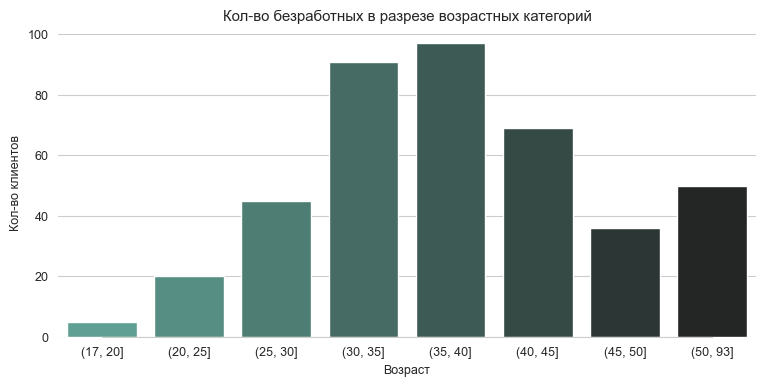

In [59]:
fig, ax = plt.subplots(figsize=(9, 4))
ax = sns.countplot(x='categories_age', data=unemployed_data, palette='dark:#5A9_r' ,ax=ax)
ax.set_title('Кол-во безработных в разрезе возрастных категорий')
ax.set_xlabel('Возраст')
ax.set_ylabel('Кол-во клиентов')
sns.despine(fig=fig, ax=ax, left=True, trim=True)
plt.show()

Оус, наши предположения оказались неверными. Оказывается большое количество клиентов, не имеющих трудового стажа принадлежат категориям `30-35` и `35-40`, а также `40-45`. При этом видим также большое кол-во клиентов в категории `50+`. А вот в категориях `до 25` клиентов не так уж и много.

Наше прежнее предположение было ложным.

Опираясь на визуальное представление данных можно осмелиться предположить, что это стаж работы на предыдущем месте. И клиенты в статусе `безработный` длительный срок имеют трудовой стаж равный 0. В таком случае у таких клиентов должна отсутствовать заработная плата. Посмотрим визуально на график зависимости заработной платы от возраста для безработных клиентов.

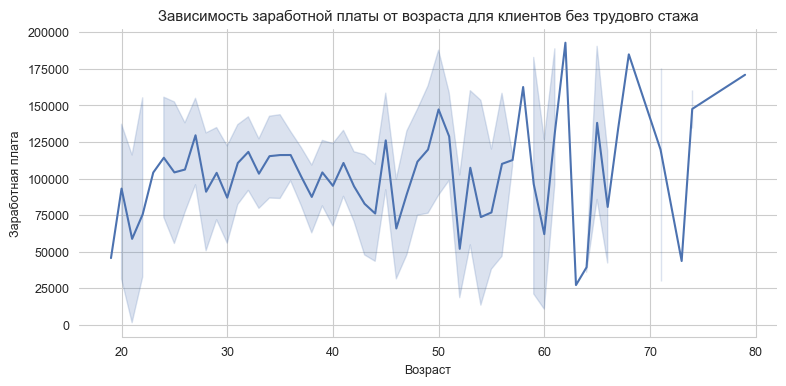

In [102]:
fig, ax = plt.subplots(figsize=(9, 4))
ax = sns.lineplot(x='Age', y='EstimatedSalary', data=unemployed_data, palette='dark:#5A9_r', ax=ax)
ax.set_title('Зависимость заработной платы от возраста для клиентов без трудовго стажа')
ax.set_xlabel('Возраст')
ax.set_ylabel('Заработная плата')
sns.despine(fig=fig, ax=ax, left=True, trim=True)
plt.show()

В очередной раз наше предположение оказалось ложным. Можем обратить внимание, что клиенты без трудового стажа в любом возрасте имеют заработную плату. Это выглядит достаточно странно. Мы можем предположить, что такие клиенты являются инвесторами, но к сожалению в рамках ограниченных данных мы не можем прийти к однозначному выводу, почему мы получили такие результаты.

Попробуем посмотреть на клиентов с нулевыми остатками на счетах.

In [68]:
data[data['Balance']==0].shape

(3617, 13)

Можем предположить, что такие клиенты получают заработную плату на карту кредитной организации, но переводят денежные средства в на другую карту, либо же используют наличные. Позже мы еще посмотрим зависимость оттока клиента от баланса.

Ранее мы обнаружили в данных достаточно низкую заработную плату в `$11.58`. Попробуем посмотреть на такие выбросы. Для этого, отсечем некоторых клиентов.

In [86]:
# посмотрим на квантили заработной платы с шагом в 0.01
for x in range(1, 5+1):
    print('Quantile {:0.2}:'.format(x/100), round(data['EstimatedSalary'].quantile(x/100), 2))

Quantile 0.01: 1842.83
Quantile 0.02: 3769.45
Quantile 0.03: 5811.3
Quantile 0.04: 8064.78
Quantile 0.05: 9851.82


Однопроцентный квантиль содержит вполне более адекватные данные. В таком случае попробуем сделать экспертную оценку и ограничим данные с заработной платой, не превышающей `$500`.

In [97]:
min_salary_data = data[data['EstimatedSalary'] <= 500].copy()

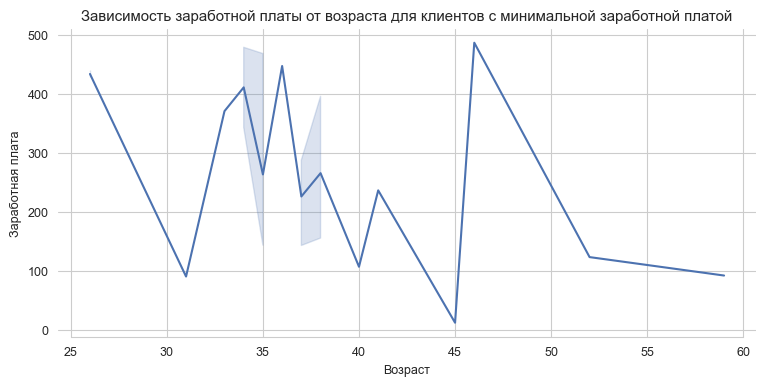

In [103]:
fig, ax = plt.subplots(figsize=(9, 4))
ax = sns.lineplot(x='Age', y='EstimatedSalary', data=min_salary_data, palette='dark:#5A9_r', ax=ax)
ax.set_title('Зависимость заработной платы от возраста для клиентов с минимальной заработной платой')
ax.set_xlabel('Возраст')
ax.set_ylabel('Заработная плата')
sns.despine(fig=fig, ax=ax, left=True, trim=True)
plt.show()

И здесь наше предположение оказалось ложным. Наименьшую заработную плату получает клиент в возрасте 45 лет, но в целом по графику заработная плата не опускается ниже `$100`. Посмотрим на этого клиента.

In [108]:
print(data[data['EstimatedSalary']==data['EstimatedSalary'].min()].T)

                      2362
CustomerId        15791053
Surname           Lucciano
CreditScore            709
Geography          Germany
Gender                Male
Age                     45
Tenure                   4
Balance          122917.71
NumOfProducts            1
HasCrCard                1
IsActiveMember           1
EstimatedSalary      11.58
Exited                   1


На первый взгляд бросается в глаза высокий уровень остатка на счете и высокий скоринговый балл. Для такой заработной платы это является странным. Но такой клиент один, пока оставим его. В дальнейшем мы еще посмотрим влияет ли уровень заработной платы на отток клиентов.

В целом на первый взгляд данные не имеют каких-то явных конфликтов с логикой. Конечно, встречаются моменты которые вызывают некоторые дополнительный вопросы, но в рамках имеющейся информации можем сказать, что данные вполне адекватны для дальнейшего анализа.

### Влияние факторов на отток клиента
Можно приступить к следующей части анализа, а именно влияние факторов, которые мы оценивали с точки зрения корректности на предыдущем шаге на отток клиентов.

Т.к. мы имеем достаточно большое кол-во параметров, создадим функцию для беглой оценки их влияния на отток.

In [173]:
def analysis_churn(df, parameter, visible_crosstab=True):
    # построение графика
    fig, ax = plt.subplots(figsize=(9, 4))
    ax = sns.countplot(x=parameter, hue='Exited', data=df, palette='dark:#5A9_r' ,ax=ax)
    ax.set_title(f'Влияние фактора {parameter} на отток клиентов')
    ax.set_xlabel(parameter)
    ax.set_ylabel('Кол-во клиентов')
    sns.despine(fig=fig, ax=ax, left=True, trim=True)
    plt.show()
    
    if visible_crosstab: print(pd.crosstab(index=df['Exited'], columns=df[parameter], normalize='columns'))
    else: pass
    
    return None

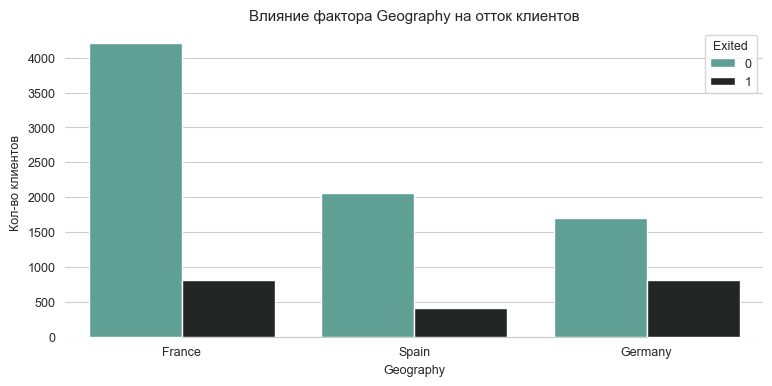

Geography    France   Germany     Spain
Exited                                 
0          0.838452  0.675568  0.833266
1          0.161548  0.324432  0.166734


In [174]:
analysis_churn(data, 'Geography')

Оус, и сразу у нас наблюдается большой отток клиентов по географическому признаку. По графику и по таблице из нашей функции `analysis_churn` видно, что наибольший отток клиентов происходит в Германии.

Сначала предлагаю посмотреть на все категориальные переменные по порядку.

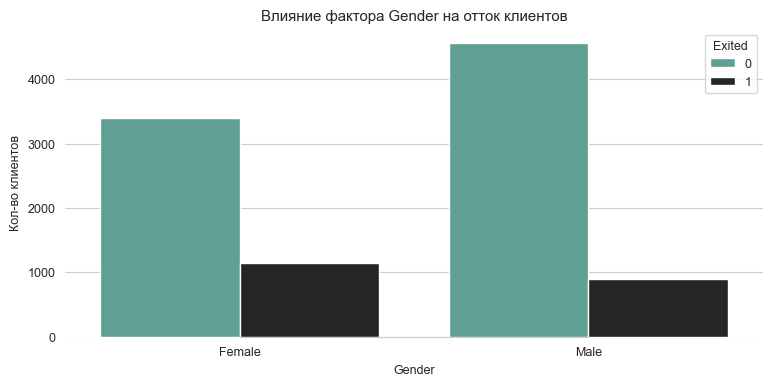

Gender    Female      Male
Exited                    
0       0.749285  0.835441
1       0.250715  0.164559


In [176]:
analysis_churn(data, 'Gender')

На первый взгляд, половой признак также влияет на отток клиентов. Мы наблюдаем, что покидает банк больше женщин, чем мужчин.

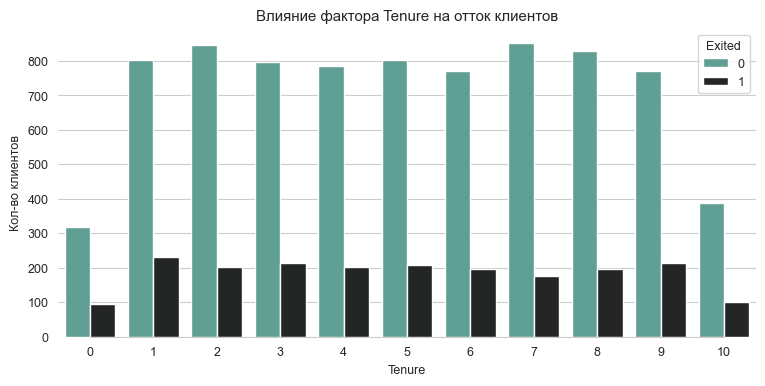

Tenure        0         1         2       3         4         5         6   \
Exited                                                                       
0       0.769976  0.775845  0.808206  0.7889  0.794742  0.793478  0.797311   
1       0.230024  0.224155  0.191794  0.2111  0.205258  0.206522  0.202689   

Tenure        7         8         9         10  
Exited                                          
0       0.827821  0.807805  0.783537  0.793878  
1       0.172179  0.192195  0.216463  0.206122  


In [177]:
analysis_churn(data, 'Tenure')

На первый взгляд, трудовой стаж никак не влияет на отток клиентов. В дальнейшем мы конечно это еще проверим.

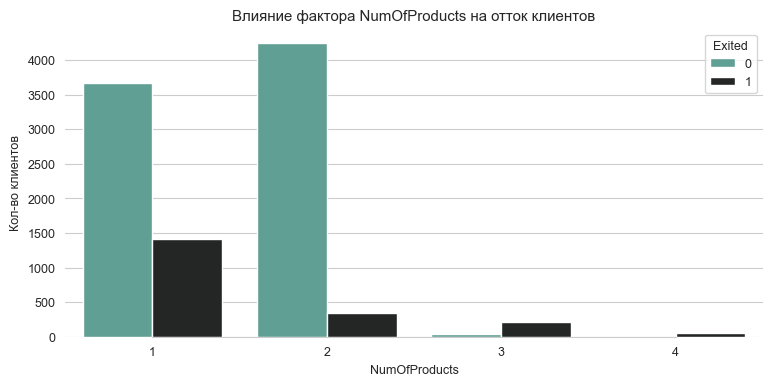

NumOfProducts         1         2         3    4
Exited                                          
0              0.722856  0.924183  0.172932  0.0
1              0.277144  0.075817  0.827068  1.0


In [178]:
analysis_churn(data, 'NumOfProducts')

Вообще, на первый взгляд, влияние данного фактора не совсем согласуется с нашей логикой. Вообще, чем больше клиент имеет продуктов в банке, тем он более лоялен к нему, но мы наблюдаем обратную картину. Большая доля клиентов имеющих 3 и более продуктов покидает банк. В то время, как и наблюдается большой отток клиентов, имеющих всего один продукт.

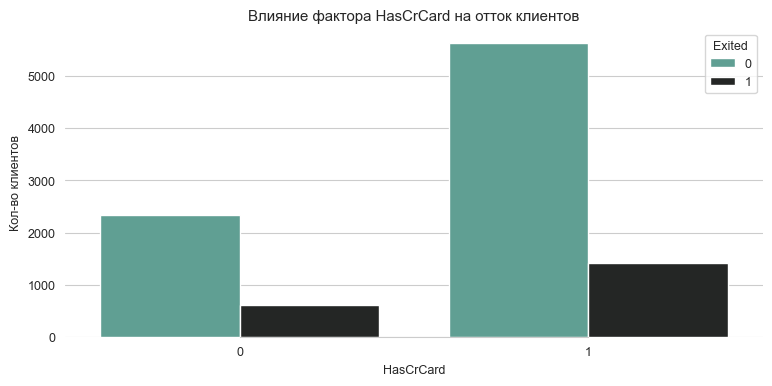

HasCrCard         0         1
Exited                       
0          0.791851  0.798157
1          0.208149  0.201843


In [179]:
analysis_churn(data, 'HasCrCard')

На первый взгляд, наличие у клиента кредитной карты никак не влияет на отток.

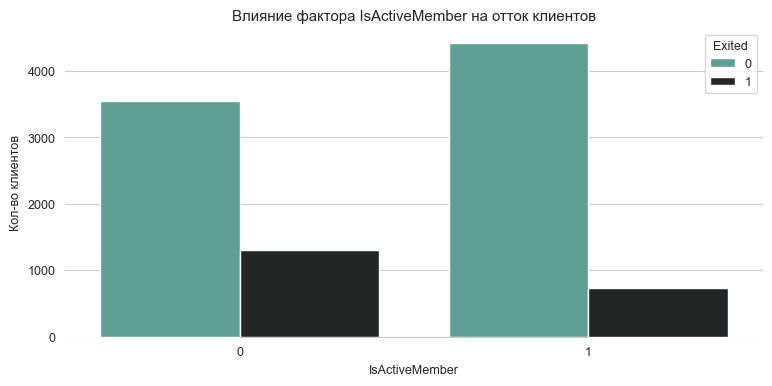

IsActiveMember         0         1
Exited                            
0               0.731491  0.857309
1               0.268509  0.142691


In [180]:
analysis_churn(data, 'IsActiveMember')

А фактор активности клиента вполне согласуется с нашей логикой. Активные клиенты реже покидают банк, чем менее активные.

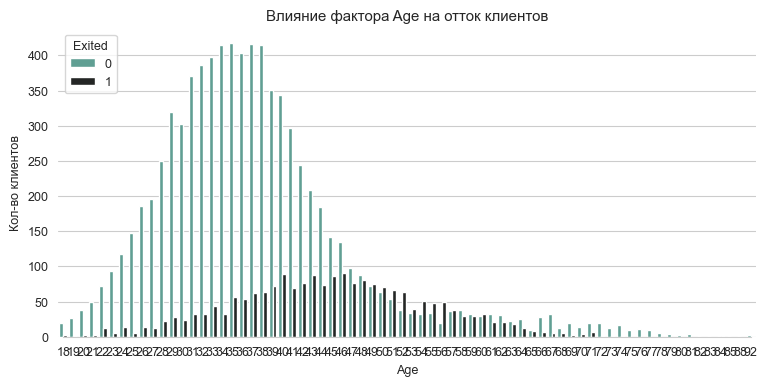

In [181]:
analysis_churn(data, 'Age', visible_crosstab=False)

Данный график не совсем информативем с точки зрений горизонтальной шкалы, но имеет явную картину. Наиболее лояльные пользователи, это более молодые и зрелые клиенты.

Для удобного отображения графиков, имеющих числовые дискретные и непрерывные величины не много скорректируем нашу функцию.

In [194]:
def analysis_churn_modif(df, parameter, ro=3):
    
    # трансформация данных
    df = pd.crosstab(index=df['Exited'], columns=df[parameter], normalize='columns').T \
        .rolling(window=ro).mean().reset_index().melt(parameter)
    
    # построение графика
    fig, ax = plt.subplots(figsize=(9, 4))
    ax = sns.lineplot(x=parameter, y='value', hue='Exited', data=df, palette='dark:#5A9_r', ax=ax)
    ax.set_title(f'Влияние фактора {parameter} на отток клиентов')
    ax.set_xlabel(parameter)
    ax.set_ylabel('Кол-во клиентов')
    sns.despine(fig=fig, ax=ax, left=True, trim=True)
    plt.show()
    
    return None

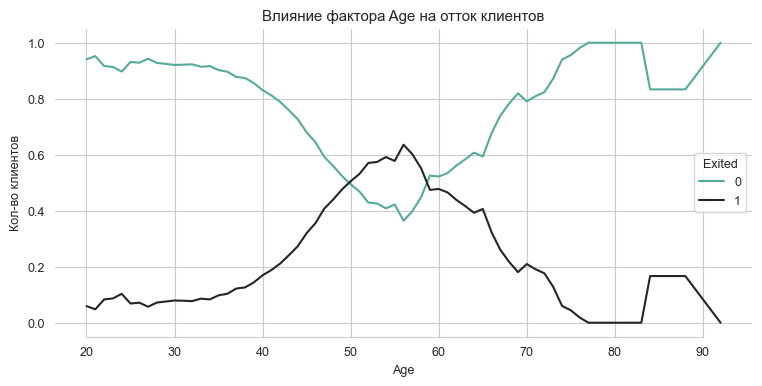

In [195]:
analysis_churn_modif(data, 'Age')

Мы наблюдаем интересную картину. В возрасте, `примерно, 55 лет` у нас наибольший отток клиентов с постепенным увеличением к этой точке и дальнейшим снижением.

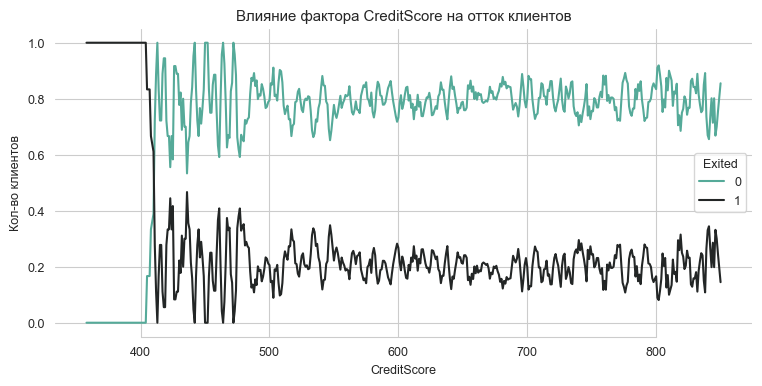

In [197]:
analysis_churn_modif(data, 'CreditScore')

А в разрезе скоринга мы явно наблюдаем, что клиенты покидают банк со скорингом менее `~ 400`. При этом, клиенты имеющие скоринговый балл `от 400 до 500` более волатильны, чем клиенты со скоринговым баллом `от 500`. Это также согласуется с логикой.

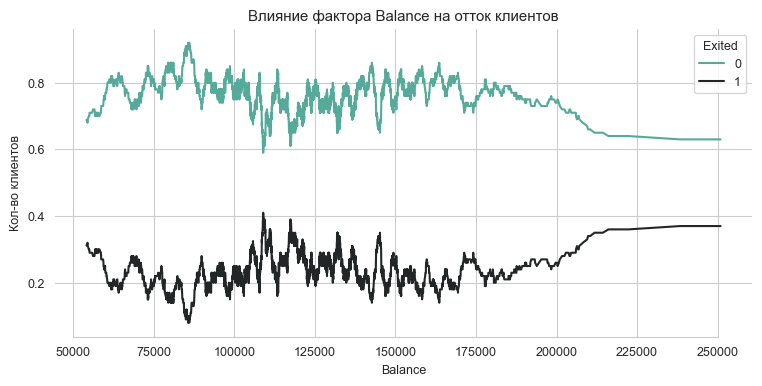

In [200]:
analysis_churn_modif(data, 'Balance', ro=100)

При рассмотрении факторов сумм мне пришлось увеличить окно, чтобы визуально данные имели смысл.

Можем обратить внимание, что до определенного остатка на счетах отток клиентов имел снижение, а после этой точки увеличение с достаточной волатильностью. Волатильность практически пропадает при больших остатках. Вероятнее всего, таких данных единицы, поэтому они имеют меньшую волатильность. При этом я замечаю достаточно высокий отток клиентов с большими остатками на счетах. Вообще на банковский бизнес это может оказать большое негативное влияние.

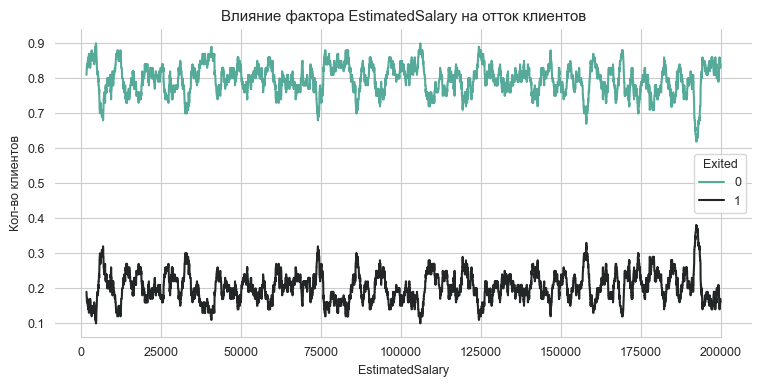

In [201]:
analysis_churn_modif(data, 'EstimatedSalary', ro=100)

На первый взгляд заработная плата никак не влияет на отток клиентов. Это пока что предположение, которое мы проверим чуть позже.

Мы проанализировали все факторы. Оценим влияние всех этих факторов друг на друга. Для этого построим корреляционную матрицу.

In [220]:
corr = data.loc[:, 'CreditScore':].corr().mul(100)

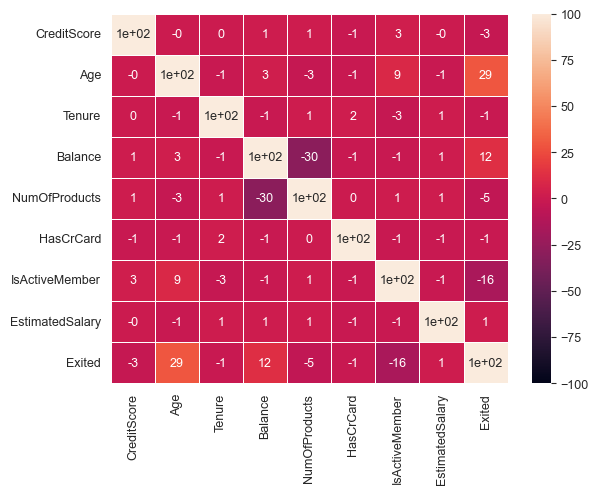

In [221]:
ax = sns.heatmap(corr.round(0), vmin=-100, vmax=100, annot=True, linewidth=.5)

Мы наблюдаем, что большинство параметров независимы друг от друга. Это отлично. Также наблюдается такой интересный факт: количество продуктов отрицательно коррелирует с балансом, а возраст положительно коррелирует с оттоком. Также активность отрицательно коррелирует с оттоком.

Что это значит?
* Это означает, что при увеличении возраста, более вероятно, что клиент покинет банк. Ранее мы наблюдали этот факт, когда рассматривали влияние возраста на отток. А также при первичном анализе данных мы могли обратить внимание, что `медиана возраста равняется 37 лет`.
* Отрицательная корреляция показателей Баланса и кол-ва продуктов говорит нам о том, что чем больше у клиента продуктов, тем меньше его баланс. В условии задачи не указано о каких именно продуктах идет речь, но на первый взгляд это не согласуется с логикой.
* Ну и отрицательную корреляцию оттока и активности клиентов мы также ранее наблюдали, когда строили зависимости. Это можно интерпретировать так: с увеличением активности клиента, уменьшается вероятность, что он покинет банк и наоборот, что является вполне логичным.

In [235]:
use_cols = ['Age', 'Balance', 'NumOfProducts', 'IsActiveMember', 'Exited']
corr2 = data[use_cols].corr()

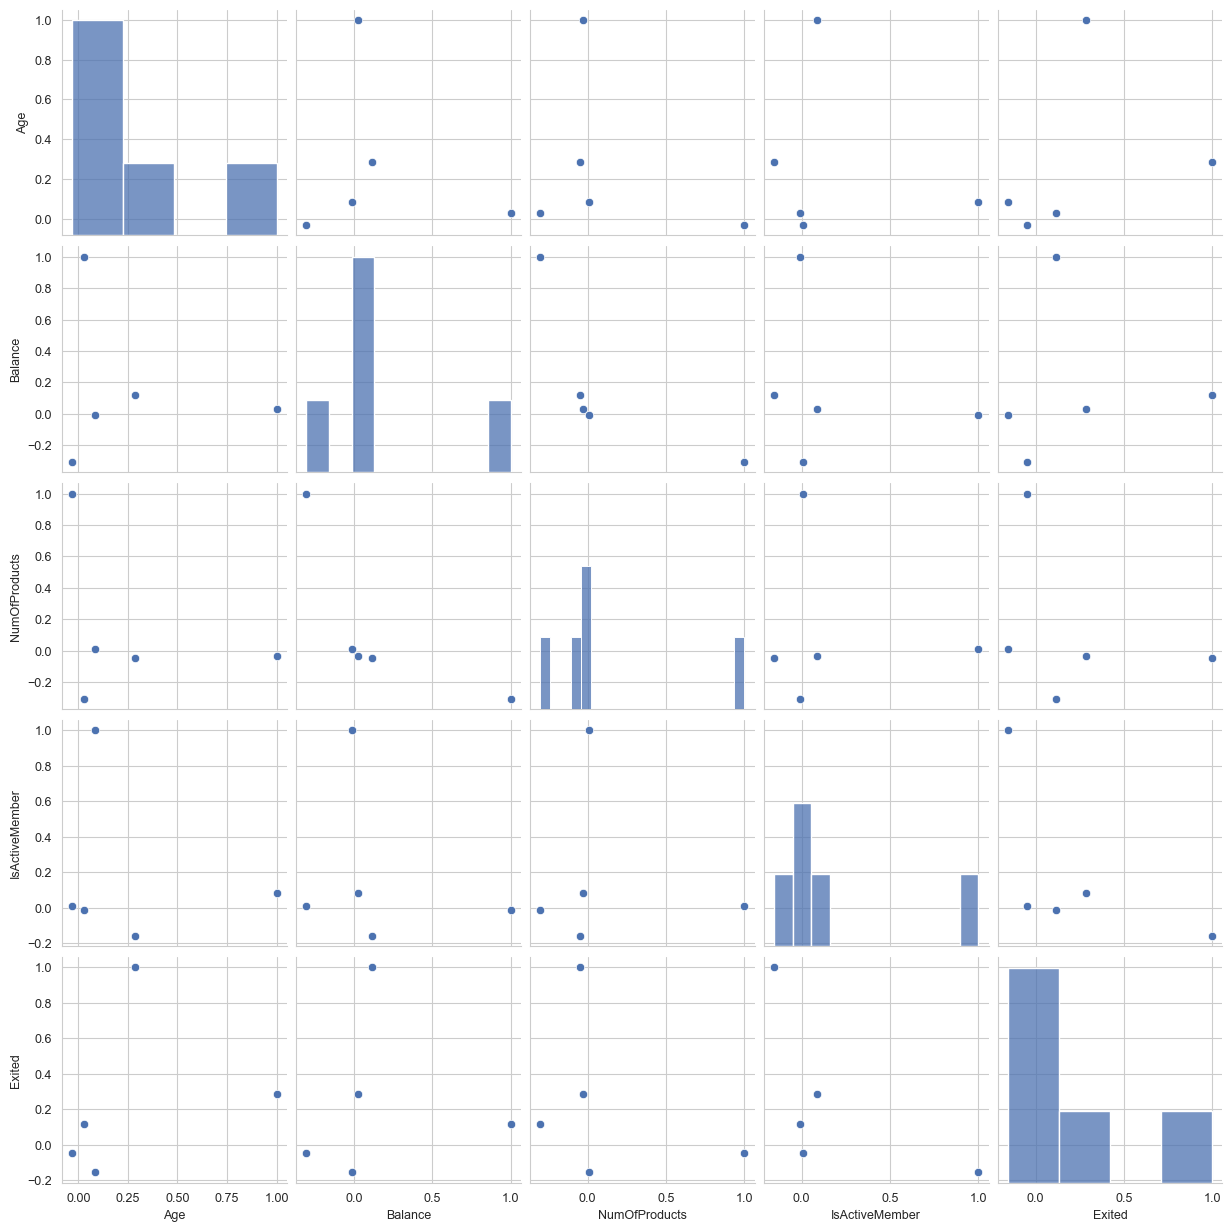

In [236]:
sns.pairplot(corr2)

Я попробовал построить график для визуального представления наиболее сильно коррелирующих между собой факторов, но к сожалению данный график оказался не очень информативен.